# Testing of Structure Learning Algorithms on Standardised vs Non-standardised Synthetic Data

This notebook is designed to test various structure learning algorithms on synthethic data that is non-standardised and compare the performance on synthethic data that is standardised.   

Standardisation is done via the process described in: https://arxiv.org/pdf/2406.11601 

In [53]:
# Importing of Required Libraries
# Ensure working directory is structure_learning/src
import numpy as np
import pcalg
import networkx as nx
from conditional_independence import partial_correlation_suffstat, partial_correlation_test
from mcmc.mcmc import PartitionMCMC
from mcmc.data import SyntheticDataset
from mcmc.proposals import PartitionProposal
from mcmc.scores import BGeScore
import pandas as pd
from mcmc.utils.graph_utils import plot_graph_from_adj_mat
from mcmc.mcmc import StructureMCMC
from mcmc.proposals import GraphProposal
from mcmc.utils.graph_utils import generate_key_from_adj_matrix
from collections import deque # new package required for standardised synthethic data class for topological ordering of DAG

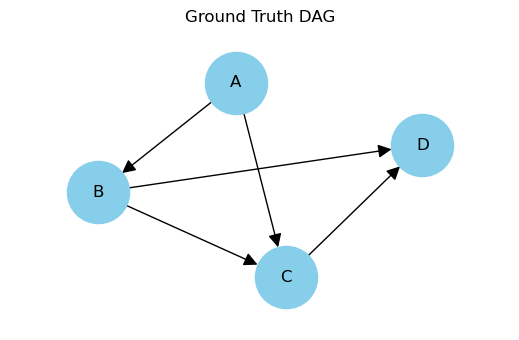

In [54]:
nodes = ['A', 'B', 'C', 'D']
node_to_index = {node: idx for idx, node in enumerate(nodes)}

# Ground truth adjacency matrix
Adj = np.array([
    [0, 1, 1, 0],  # A -> B, A -> C
    [0, 0, 1, 1],  # B -> C, B -> D
    [0, 0, 0, 1],  # C -> D
    [0, 0, 0, 0]   # D has no children
])

# Set Seed for Reproducibility of Analysis
np.random.seed(123)

# Number of samples
n_samples = 1000

# Weights for the edges
weights = {
    ('A', 'B'): 0.8,
    ('A', 'C'): 0.5,
    ('B', 'C'): 1.0,
    ('B', 'D'): 0.6,
    ('C', 'D'): 0.7,
}

# Initialize data dictionary
data = {node: np.zeros(n_samples) for node in nodes}

# Generate data in topological order
# 1. Generate data for A (root node)
data['A'] = np.random.normal(0, 1, size=n_samples)

# 2. Generate data for B
data['B'] = (weights[('A', 'B')] * data['A'] + np.random.normal(0, 1, size=n_samples))

# 3. Generate data for C
data['C'] = (weights[('A', 'C')] * data['A'] + weights[('B', 'C')] * data['B'] + np.random.normal(0, 1, size=n_samples))

# 4. Generate data for D
data['D'] = (weights[('B', 'D')] * data['B'] + weights[('C', 'D')] * data['C'] + np.random.normal(0, 1, size=n_samples))

# Convert data to pandas DataFrame
df = pd.DataFrame(data)

# Visualising
plot_graph_from_adj_mat(Adj, nodes, title="Ground Truth DAG")

## Testing of Variance of Parent Nodes vs Children's Node's for Synthetic Data

In [55]:
np.var(data['A'])

1.001575695247806

In [56]:
np.var(data['B'])

1.5108012020517119

In [57]:
np.var(data['D'])

4.579381043246217

We will now generate a synthetic DAG from the function within the `structure_learning` repo

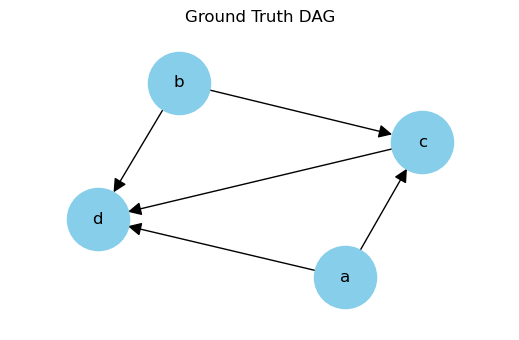

In [58]:
num_nodes = 4
node_labels = [chr(ord('a') + i) for i in range(num_nodes)]
num_obs = 200
degree = 2

np.random.seed(123)
synthetic_data = SyntheticDataset(num_nodes=num_nodes, num_obs=num_obs, node_labels=node_labels, degree=degree)

plot_graph_from_adj_mat(synthetic_data.adj_mat.values, node_labels, title="Ground Truth DAG")

In [59]:
print(synthetic_data.adj_mat.values)

[[0 0 1 1]
 [0 0 1 1]
 [0 0 0 1]
 [0 0 0 0]]


In [60]:
np.var(synthetic_data.data['a'])

1.0654105569716201

In [61]:
np.var(synthetic_data.data['c'])

3.026771266212829

In [62]:
np.var(synthetic_data.data['d'])

9.44990602187281

In [63]:
np.var(synthetic_data.data['b'])

0.8834791960745515

### Synthetic Dataset class with standardised data

We define a new class that standardises the data. We will use structure learning on the datasets created via each method and see the difference in the posterior distribution of graph structures

In [74]:
class Standardised_Synthetic_Data(object):
    """
    Generate standardised synthetic data from graphs.
    """
    def __init__(
        self,
        num_nodes: int,
        num_obs: int,
        node_labels: list,
        degree: float,
        graph_type: str = "erdos-renyi",
        noise_scale: float = 1.0,
        true_dag = None):
        """
        Initialise SyntheticDataset instance
        """
        self.num_nodes = num_nodes
        self.num_obs = num_obs
        self.node_labels = node_labels
        self.degree = degree
        self.graph_type = graph_type
        self.noise_scale = noise_scale
        self.w_range = (0.5, 2.5)
        self.true_dag = true_dag

        self._setup()

    def _setup(self):
        """
        Initial setup. Simulates random dag (if not given) and data.
        """
        self.W, _, self.P = self.simulate_random_dag(
            self.num_nodes,
            self.degree,
            self.graph_type,
            self.w_range
        )

        if self.true_dag is None:
            self.data = pd.DataFrame(self.simulate_data(
                self.W,
                self.num_obs
            ), columns=self.node_labels)
        else:
            self.data, self.W = self.simulate_data_from_dag(
                self.true_dag,
                self.num_obs,
                self.num_nodes,
                self.node_labels,
                self.w_range,
                self.noise_scale
            )

        self.adj_mat = pd.DataFrame(np.where(self.W != 0, 1, 0), columns=self.node_labels)

    @staticmethod
    def simulate_random_dag(d, degree, graph_type, w_range):
        """Simulate random DAG with some expected degree.
        Parameters:
            d (int): number of nodes
            degree (int): expected node degree, in + out
            graph_type (str): {erdos-renyi, barabasi-albert, full}
            w_range (2-tuple (float)): weight range +/- (low, high)
        Returns:
            (numpy.ndarray): weighted DAG
            None
            (numpy.ndarray): permutation matrix
        """
        if graph_type == "erdos-renyi":
            prob = float(degree) / (d - 1)
            B = np.tril((np.random.rand(d, d) < prob).astype(float), k=-1)
        elif graph_type == "barabasi-albert":
            m = int(round(degree / 2))
            B = np.zeros([d, d])
            bag = [0]
            for ii in range(1, d):
                dest = np.random.choice(bag, size=m)
                for jj in dest:
                    B[ii, jj] = 1
                bag.append(ii)
                bag.extend(dest)
        elif graph_type == "full":  # ignore degree, only for experimental use
            B = np.tril(np.ones([d, d]), k=-1)
        else:
            raise ValueError("Unknown graph type")
        # random permutation
        P = np.random.permutation(np.eye(d, d))  # permutes first axis only
        B_perm = P.T.dot(B).dot(P)
        U = np.random.uniform(low=w_range[0], high=w_range[1], size=[d, d])
        U[np.random.rand(d, d) < 0.5] *= -1
        W = (B_perm != 0).astype(float) * U

        # At the moment the generative process is P.T @ lower @ P, we want
        # it to be P' @ upper @ P'.T.
        # We can return W.T, so we are saying W.T = P'.T @ lower @ P.
        # We can then return P.T, as we have
        # (P.T).T @ lower @ P.T = W.T

        return W.T, None, P.T

    @staticmethod
    def topological_sort(adj_matrix):
        """
        Sort the random dag that has been generated topologically. 
        i.e. Source Nodes first and absorbing nodes last
        """   
        num_nodes = adj_matrix.shape[0]
        in_degree = np.zeros(num_nodes, dtype=int)
        for i in range(num_nodes):
            for j in range(num_nodes):
                if adj_matrix[i, j] != 0:
                    in_degree[j] += 1
        
        queue = deque([i for i in range(num_nodes) if in_degree[i] == 0])
        top_order = []
        
        while queue:
            node = queue.popleft()
            top_order.append(node)
            for j in range(num_nodes):
                if adj_matrix[node, j] != 0:
                    in_degree[j] -= 1
                    if in_degree[j] == 0:
                        queue.append(j)
    
        return top_order

    @staticmethod
    def simulate_data(adj_matrix, num_obs):
        """Simulate data from the weighted DAG."""
        num_nodes = adj_matrix.shape[0]
        data = np.zeros((num_obs, num_nodes))
        
        # Get topological order of nodes
        top_order = Standardised_Synthetic_Data.topological_sort(adj_matrix)
        
        for node in top_order:
            parents = [i for i in range(num_nodes) if adj_matrix[i, node] != 0]
            if not parents:
                # If no parents, generate data independently
                data[:, node] = np.random.randn(num_obs)
            else:
                # Manually extract and combine parent columns
                parent_values_list = []
                for parent in parents:
                    # Extract Parent Values
                    parent_values = data[:, parent].reshape(-1, 1)
                    # Standardising each parent node
                    parent_values_standardised = (parent_values - np.mean(parent_values)) / np.std(parent_values)
                    # Append to list
                    parent_values_list.append(parent_values_standardised)
                
                # Combine all parent columns into a single array
                parent_values_combined = np.hstack(parent_values_list)
                
                # Generate data based on weighted sum of parent values + noise
                weights = adj_matrix[parents, node]
                data[:, node] = np.dot(parent_values_combined, weights) + np.random.randn(num_obs)
        
        return data


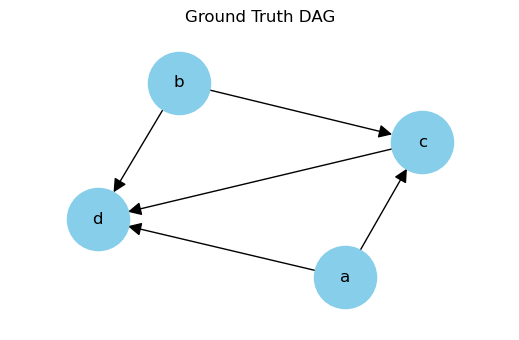

In [75]:
num_nodes = 4
node_labels = [chr(ord('a') + i) for i in range(num_nodes)]
num_obs = 200
degree = 2

np.random.seed(123)
synthetic_data_standardised = Standardised_Synthetic_Data(num_nodes=num_nodes, num_obs=num_obs, node_labels=node_labels, degree=degree)

plot_graph_from_adj_mat(synthetic_data_standardised.adj_mat.values, node_labels, title="Ground Truth DAG")

In [76]:
# Check that they did indeed create different datasets
synthetic_data.data.equals(synthetic_data_standardised.data)

False

In [81]:
print(np.var(synthetic_data.data['a']))
print(np.var(synthetic_data.data['d']))

1.0654105569716201
9.44990602187281


In [82]:
print(np.var(synthetic_data_standardised.data['a']))
print(np.var(synthetic_data_standardised.data['d']))

0.9591053902943532
4.719075043941822


We can see that the variance of children's nodes in the standardised data set is indeed much smaller than in the unstandardised data. Though, the variance in the child's node is still higher than the parent nodes - likely due to the standardisation process standardising wihtin the data generation process (rather than standardising post data-generation)

### Running Structure Learning on Both Synthetic Datasets

In [113]:
# Setup
np.random.seed(123)
n_iterations = 100000
# Running for Unstandardised Data
M = StructureMCMC(data=synthetic_data.data, max_iter=n_iterations)
# Running for Standardised Data
M_standardised = StructureMCMC(data = synthetic_data_standardised.data, max_iter= n_iterations)

Running PC algorithm
Running PC algorithm


Checking if True DAG is in each of the results from each structure learning 

In [114]:
# Unstandardised Data
mcmc_results, acceptance = M.run()
graphs = M.get_mcmc_res_graphs(mcmc_results)
key = generate_key_from_adj_matrix(synthetic_data.adj_mat.values)
keys, counts = np.unique([generate_key_from_adj_matrix(g) for g in graphs], return_counts=True)
print(key in keys)
print('Acceptance Ratio:', acceptance)

True
Acceptance Ratio: 0.194


In [115]:
# Standardised Data
mcmc_results_standardised, acceptance_standardised = M_standardised.run()
graphs_standardised = M_standardised.get_mcmc_res_graphs(mcmc_results_standardised)
key_standardised = generate_key_from_adj_matrix(synthetic_data_standardised.adj_mat.values)
keys_standardised, counts_standardised = np.unique([generate_key_from_adj_matrix(g) for g in graphs_standardised], return_counts = True)
print(key_standardised in keys_standardised)
print('Acceptance Ratio:', acceptance_standardised)


True
Acceptance Ratio: 0.1286


In [116]:
print(key_standardised)
print(key)

0011 0011 0001 0000
0011 0011 0001 0000


In [117]:
print(len(keys))
print(len(keys_standardised))

41
43


The true DAG is within the 

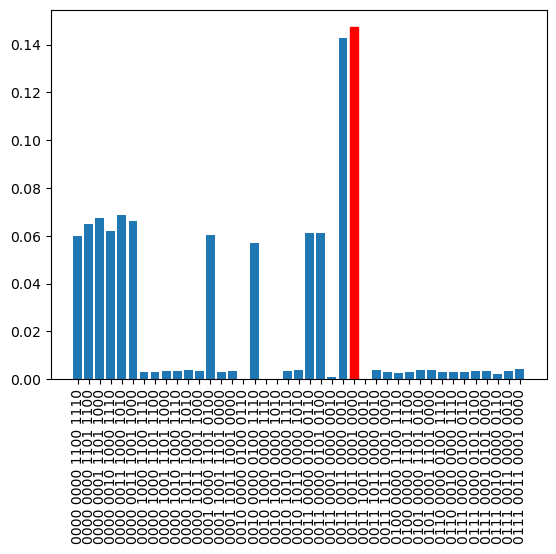

In [118]:
from matplotlib import pyplot as plt

bars = plt.bar(range(len(keys)), counts/len(graphs))
plt.xticks(range(len(keys)), keys, rotation=90)
bars[np.where(keys==key)[0][0]].set_color('red') 

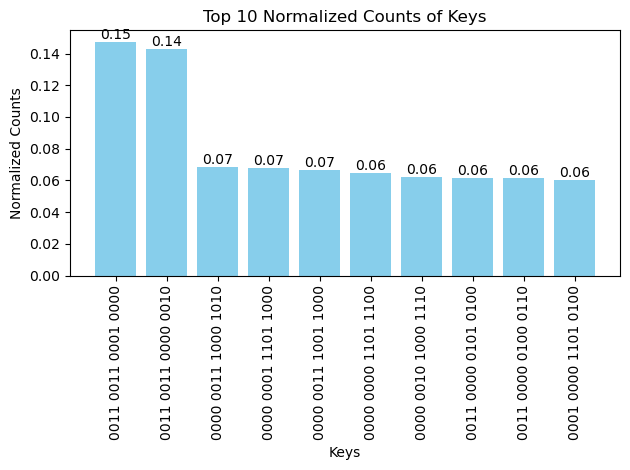

In [119]:
# Combine keys and counts into a list of tuples and sort by counts in descending order
sorted_data = sorted(zip(keys, counts), key=lambda x: x[1], reverse=True)

# Select the top 10 keys and counts
top_keys, top_counts = zip(*sorted_data[:10])

# Plotting the bar chart with the top 10 values
bars = plt.bar(range(len(top_keys)), [count / len(graphs) for count in top_counts], color='skyblue')

# Adding x-tick labels and rotating them for readability
plt.xticks(range(len(top_keys)), top_keys, rotation=90)

# Adding labels and title
plt.xlabel('Keys')
plt.ylabel('Normalized Counts')
plt.title('Top 10 Normalized Counts of Keys')

# Displaying the values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Adjust layout to prevent clipping
plt.tight_layout()
plt.show()

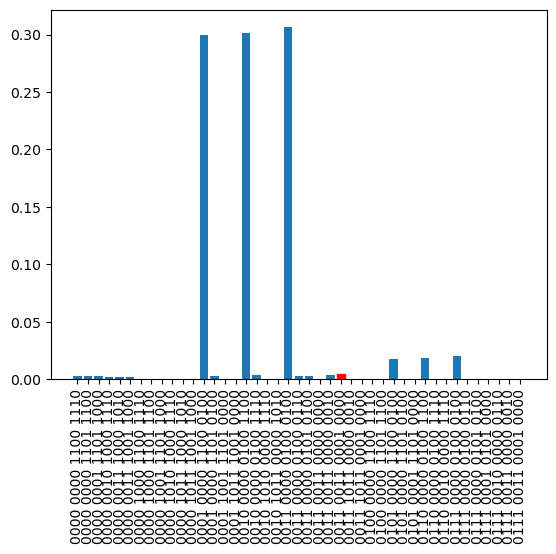

In [120]:
bars = plt.bar(range(len(keys_standardised)), counts_standardised/len(graphs_standardised))
plt.xticks(range(len(keys_standardised)), keys_standardised, rotation = 90) # Keep the x axis range the same so we can compare the two charts
bars[np.where(keys_standardised==key_standardised)[0][0]].set_color('red')

#### Lets try again with Partition MCMC 


In [95]:
# Unstandardised
M_partition = PartitionMCMC(max_iter = n_iterations, data=synthetic_data.data, score_object='bge')
# Standardised 
M_partition_standardised = PartitionMCMC(max_iter = n_iterations, data = synthetic_data_standardised.data, score_object = 'bge')

Running PC algorithm
Running PC algorithm


Checking if true dag is in distribution created by partition mcmc

In [96]:
# Unstandardised Data
mcmc_results, acceptance = M_partition.run()
graphs = M.get_mcmc_res_graphs(mcmc_results)
key = generate_key_from_adj_matrix(synthetic_data.adj_mat.values)
keys, counts = np.unique([generate_key_from_adj_matrix(g) for g in graphs], return_counts=True)
print(key in keys)

True


In [97]:
# Standardisied Data
mcmc_results_standardised, acceptance_standardised = M_partition_standardised.run()
graphs_standardised = M_standardised.get_mcmc_res_graphs(mcmc_results_standardised)
key_standardised = generate_key_from_adj_matrix(synthetic_data_standardised.adj_mat.values)
keys_standardised, counts_standardised = np.unique([generate_key_from_adj_matrix(g) for g in graphs_standardised], return_counts = True)
print(key_standardised in keys_standardised)


True
